# Rewards of Perfect Market Timing

**_Timothy R. Mayes, Ph.D. (http://www.tvmcalcs.com)_**  
*1 January 2019*

*******
This code will calculate the rewards that can be had given great skill at market timing. It shows the value of a portfolio where the trader is good enough to be out of the market on the worst *N* days between the start and end dates. Obviously, this is not possible in reality, but it is interesting.

The impetus for this idea was [“The Truth About Timing,” by Jacqueline Doherty, Barron’s (November 5, 2001)](https://www.barrons.com/articles/SB1004756712494481760). In order to replicate those results, load the data and then call the `total_returns` function as:

```total_returns(data['1/1/1966':'10/29/2001'],5,invest=1).round(2)```

Actually, the exact dates that were used isn't clear. The chart in the article says that it starts in Feb 1966, but the table implies that it starts at the beginning of 1966 (3 January 1966). Also, there may be some slight rounding or data issues that cause the results here to vary a bit from the results reported in the Barron's article.

Finally, note that you can substitute your own data (different index or stock, different time frame, whatever), but this is probably best used if you have complete data for each calendar year. That is because the calculations drop the n worst/best days by calendar year.

Data is from [Yahoo! Finance](https://finance.yahoo.com/quote/%5EGSPC/history?period1=-631126800&period2=1546326000&interval=1d&filter=history&frequency=1d) as of 1 January 2019, and includes the daily adjusted close of the S&P 500 each day from 1 January 1950 to 31 December 2018.

## Import Modules and Set File Name

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

#set file name assuming it is in the same dir as notebook
file_name = os.path.join(os.getcwd(),'SP500 Daily.csv')

## Functions

In [2]:
def get_data(filename):
    '''Opens filename and returns a Pandas DataFrame containing the data. 
    The csv file should have columns named Date and Adj Close.
    The DataFrame will have index = Date, and columns Adj Close, Year, and Return'''
    data = pd.read_csv(file_name, index_col='Date', parse_dates=True)
    data['Year'] = data.index.year
    data['Return'] = data['Adj Close'].pct_change()
    return data
    
def get_n_worst(df, n):
    '''Returns a Pandas Series with the n worst days for each year'''
    return df.groupby(['Year'])['Return'].nsmallest(n)

def get_n_worst_overall(df, n):
    '''Returns a Pandas Series with the n worst days in the whole DataFrame'''
    return df['Return'].nsmallest(n)

def get_n_best(df, n):
    '''Returns a Pandas Series with the n best days for each year'''
    return df.groupby(['Year'])['Return'].nlargest(n)

def get_n_best_overall(df, n):
    '''Returns a Pandas Series with the n best days in the whole DataFrame'''
    return df['Return'].nlargest(n)

def drop_n_worst(df, n):
    '''Returns a DataFrame with the n worst days dropped'''
    worst = get_n_worst(df,n) #this is a MultiIndex Pandas Series
    return df.drop(worst.index.levels[1]) #Get the worst dates and drop them from the DataFrame

def drop_n_best(df, n):
    '''Returns a DataFrame with the n best days dropped'''
    best = get_n_best(df,n) #this is a MultiIndex Pandas Series
    return df.drop(best.index.levels[1]) #Get the worst dates and drop them from the DataFrame

def total_returns(df, n, invest=1):
    '''Returns the total returns for several portfolios:
    buy and hold, missing n worst days, missing n best days
    assuming invest dollars were invested at the beginning'''
    bh_ret = (np.product(1+df['Return'])-1) #Return for Buy and Hold all days
    drop_worst = drop_n_worst(df, n)
    miss_worst_ret = (np.product(1+drop_worst['Return'])-1) #Return for missing n worst days
    drop_best = drop_n_best(df, n)
    miss_best_ret = (np.product(1+drop_best['Return'])-1) #Return for missing n best days
    returns_df = pd.DataFrame.from_dict({'Buy and Hold':invest*(1+bh_ret), 
                                         'Miss '+str(n)+' Worst Days':invest*(1+miss_worst_ret), 
                                         'Miss '+str(n)+' Best Days':invest*(1+miss_best_ret)}, 
                                        orient='index', columns=['$'+str(invest)+' Grows to'])
    return returns_df

def total_returns_by_year(df, n):
    '''Returns a Pandas DataFrame showing the returns for each year for buy and hold, 
    dropping n worst days, and dropping n best days.'''
    returns_dict = {}
    annual_data = df.groupby(['Year']) #Group data by year
    years = list(annual_data.Year.unique().index) #Get list of years in df
    for year in years:
        bh = np.product(1+annual_data.get_group(year)['Return'])-1
        miss_worst = np.product(1+drop_n_worst(annual_data.get_group(year),n)['Return'])-1
        miss_best = np.product(1+drop_n_best(annual_data.get_group(year),n)['Return'])-1
        returns_dict[year] = [bh, miss_best, miss_worst] #Add year and returns list to dict
        colnames = ['Buy and Hold','Miss '+ str(n)+' Best Days','Miss '+str(n)+' Worst Days']
    annual_rets = pd.DataFrame.from_dict(returns_dict, orient='index', columns=colnames)
    return annual_rets
    

## Read Data File and Display First and Last Values

In [3]:
data = get_data(file_name)
pd.set_option('max_rows', 10)
display(data) #Show first 5 and last 5 data points
pd.reset_option('max_rows')

,Adj Close,Year,Return
Date,,,
1950-01-03,16.660000,1950,NaN
1950-01-04,16.850000,1950,0.011405
1950-01-05,16.930000,1950,0.004748
1950-01-06,16.980000,1950,0.002953
1950-01-09,17.080000,1950,0.005889
...,...,...,...
2018-12-24,2351.100098,2018,-0.027112
2018-12-26,2467.699951,2018,0.049594
2018-12-27,2488.830078,2018,0.008563


# Results for Entire Period

In [4]:
total_returns(data,5,invest=1).round(2)

,$1 Grows to
Buy and Hold,150.47
Miss 5 Worst Days,921415.28
Miss 5 Best Days,0.04


# Results for 1966 to 2001 (Barron's article time period)
Note: I can't quite match the results of the Barron's article. It is quite close if I start on 1/1/1966 (and that gives the exact results from the table for 1966), but I cannot determine the correct ending date. It is possible that there are slight differences in some of the data (see table below).

Obviously, the dates, number of days missed, and amount invested can be changed.

In [5]:
total_returns(data['1/1/1966':'10/29/2001'],5,invest=1).round(2)

,$1 Grows to
Buy and Hold,11.67
Miss 5 Worst Days,976.59
Miss 5 Best Days,0.15


## Reproduce Annual Return Table (Barron's article time period)
For most years, this exactly matches Barron's table at the end of the article. However, there are slight differences for the following years:

Buy and Hold: 2001

Miss 5 Best Days: 1968, 1969, 1970, 1971, 1972, 1980, 1981, 1982, 1983, 1996, 1997, 1998, 2001

Miss 5 Worst Days: 1967, 1976, 1981, 1983, 1992, 1993, 1996, 1997, 1998, 2001

The overall average difference is 0.2758% (pretty close overall). All other data points match at two decimal places.

In [6]:
returns_table = total_returns_by_year(data['1/1/1966':'10/29/2001'],5)
(returns_table*100).round(2)

,Buy and Hold,Miss 5 Best Days,Miss 5 Worst Days
1966,-13.09,-21.55,-3.53
1967,20.09,11.66,29.07
1968,7.66,-1.47,15.59
1969,-11.36,-18.43,-3.97
1970,0.10,-13.50,13.36
1971,10.79,0.36,19.40
1972,15.63,9.26,22.49
1973,-17.37,-27.23,-5.97
1974,-29.72,-42.38,-18.06
1975,31.55,15.86,45.97


## Reproduce the Chart from Barron's
Here I use matplotlib to reproduce the chart from the article as best as possible.

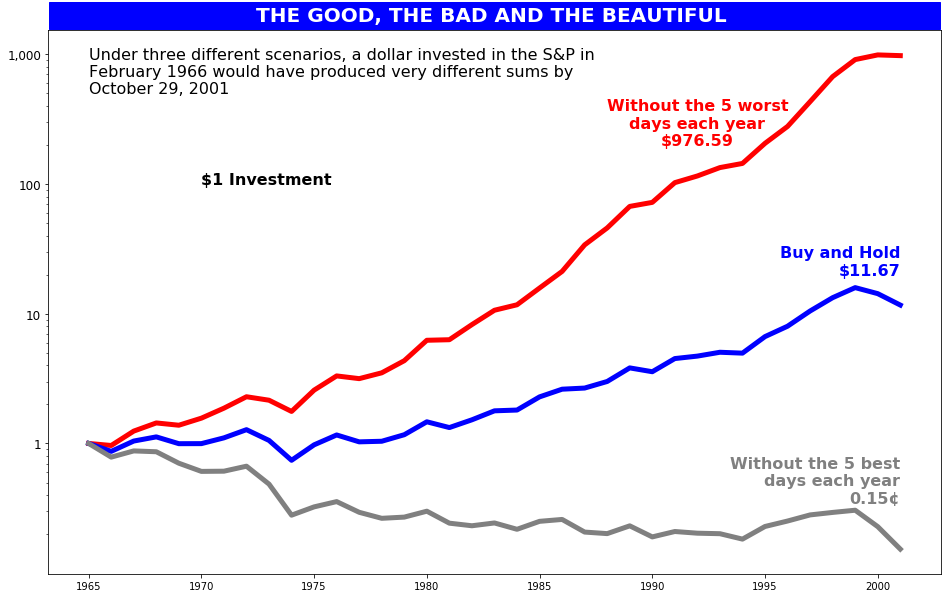

In [7]:
chart_data = (1+returns_table).cumprod()
chart_data.loc[1965] = [1,1,1] #Start at 1
chart_data.sort_index(inplace=True) #Sort by year
fig, ax = plt.subplots(figsize=(16, 10))
plt.yscale('log')
plt.gca().set_yticks([1,10,100,1000])
plt.gca().set_yticklabels(['1','10','100','1,000'], fontsize=12)
plt.title('The Good, The Bad and The Beautiful'.upper().center(94), fontdict={'fontsize':20,'fontweight':'bold'},
          color='white',backgroundcolor='blue', pad=9)
plt.annotate('$1 Investment',xy=(1970,100), fontsize=16, fontweight='bold')
best_txt = 'Without the 5 worst\ndays each year\n$'+'{:06.2f}'.format(chart_data.loc[2001]['Miss 5 Worst Days'])
plt.annotate(best_txt,xy=(1992,200), fontsize=16, fontweight='bold', color='red', horizontalalignment='center')
bh_txt = 'Buy and Hold\n$'+'{:05.2f}'.format(chart_data.loc[2001]['Buy and Hold'])
plt.annotate(bh_txt,xy=(2001,20), fontsize=16, fontweight='bold', color='blue', horizontalalignment='right')
worst_txt = 'Without the 5 best\ndays each year\n'+'{:03.2f}'.format(chart_data.loc[2001]['Miss 5 Best Days'])+chr(162)
plt.annotate(worst_txt,xy=(2001,0.35), fontsize=16, fontweight='bold', color='gray', horizontalalignment='right')
textbox_txt = ('Under three different scenarios, a dollar invested in the S&P in\n'+
                     'February 1966 would have produced very different sums by\n'+
                     'October 29, 2001')
plt.annotate(textbox_txt, xy=(1965,500), fontsize=16, color='black', horizontalalignment='left')
plt.plot(chart_data['Miss 5 Worst Days'], color='red', linewidth=5)
plt.plot(chart_data['Buy and Hold'], color='blue', linewidth=5)
plt.plot(chart_data['Miss 5 Best Days'], color='gray', linewidth=5);
#plt.savefig(os.path.join(os.getcwd(),'Barrons Chart.jpg'), dpi=300); #Uncomment to save chart as a .jpg file